In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import io
import pandas as pd
from plotnine import *
from pulp import *
from wurlitzer import sys_pipes
from typing import Optional, List, Tuple

from Knapsack import make_knapsack_model, KnapsackProblem, plot_knapsack, plot_items

theme_set(theme_bw())

# Knapsack problem

You are given a set of items $I$ with weight $w_i$ and value $p_i$ and a knapsack with capacity (maximum weight) $C$.

Your goal is to fill the knapsack with the available items in $I$ to maximize its total value.
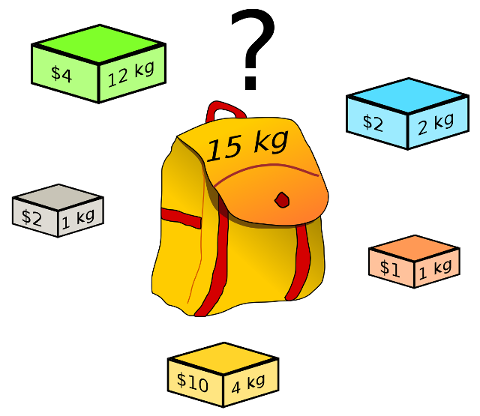

 ## Model

$\newcommand{\var}[1]{{\color{blue}{#1}}}$

Let $\var{x_i}$ be a binary variable for each item $i\in I$ such that $\var{x_i}=1$ iff $i$ is put in the knapsack.

 $$\begin{align}
 \max ~& \sum_{i\in I} p_i \var{x_i}\\
 & \sum_{i\in I} w_i \var{x_i} \le C\\
 & \var{x_i} \in \{0,1\}\quad \forall i\in I
 \end{align}
 $$
 
 ## Python (PuLP) code
 

```python

def make_knapsack_model(items_data: DataFrame, capacity:float) -> LpProblem:
"""
    items_data: items dataframe with columns `weight` and `value`
    capacity: knapsack capacity
"""
    I = list(range(len(items_data)))
    
    model = LpProblem("Knapsack",sense=LpMaximize)

    x = [LpVariable(cat=LpBinary, name=f"x_{i}") for i in I]

    total_value = lpSum(items_data["value"][i] * x[i] for i in I)
    total_weight = lpSum(items_data["weight"][i] * x[i] for i in I)

    model.addConstraint(total_weight <= capacity, "capacity_constraint")

    model.setObjective(total_value)
    
    return model
```

## Example with 10 items

Weight and value randomly distributed between 0 and 1

In [3]:
items = pd.read_csv(io.StringIO("""value,weight
0.852914,0.919548
0.235584,0.037868
0.146313,0.861563
0.589910,0.753593
0.574054,0.405238
0.061364,0.343592
0.590467,0.171000
0.245425,0.394720
0.340511,0.641702
0.984730,0.274665"""))
capacity = 0.45 * items["weight"].sum()

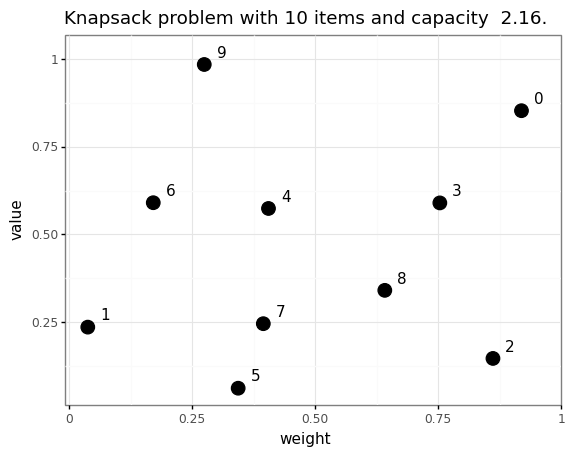

<ggplot: (8768280924856)>

In [4]:
plot_items(items, capacity)

### Solve with PuLP/CB

Log will reports the steps/heuristics used by the solver.


In [5]:
kp = make_knapsack_model(items, capacity)

with sys_pipes():
    kp.model.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ataverna/pyvenv/lagrangian_example/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/b10d8a5f19a34229ba2e42c2eafb4c69-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/b10d8a5f19a34229ba2e42c2eafb4c69-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 6 COLUMNS
At line 47 RHS
At line 49 BOUNDS
At line 60 ENDATA
Problem MODEL has 1 rows, 10 columns and 10 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 3.51427 - 0.00 seconds
Cgl0004I processed model has 1 rows, 10 columns (10 integer (10 of which binary)) and 10 elements
Cbc0038I Initial state - 1 integers unsatisfied sum - 0.468756
Cbc0038I Solution found of -3.23775
Cbc0038I Before mini branch and bound, 9 integers at bound fixed and 0 continuous
Cbc0038I Full problem 1 rows 10 columns, reduce

### Solution

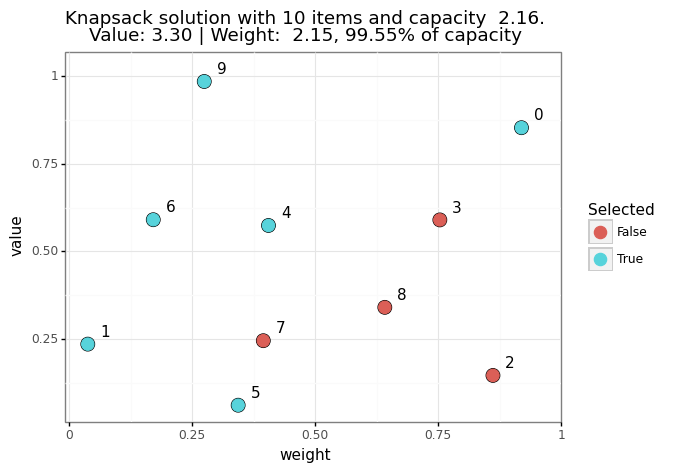

<ggplot: (8768216874725)>

In [6]:
plot_knapsack(kp)

## Interpretabilty/Explainability

The methods we use can be interpreted and explained.

Consider, for example, the following questions about item #8:
1. Why is the item not included in the optimal solution? 
2. What would happen if I was forced to put it in the knapsack?
3. How much should I ask for forcing the item in the knapsack?

We can answer those by forcing the solver to include item #8 in the knapsack

### Add constraint to force #8 selection

In [7]:
kp = make_knapsack_model(items, capacity)
kp.model.addConstraint(kp.x[8] == 1, name="force_select_8")

### Solve the new model

In [8]:
kp.model.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ataverna/pyvenv/lagrangian_example/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/dac568d759534f7991220be8beaae912-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/dac568d759534f7991220be8beaae912-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 7 COLUMNS
At line 49 RHS
At line 52 BOUNDS
At line 63 ENDATA
Problem MODEL has 2 rows, 10 columns and 11 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 3.31071 - 0.00 seconds
Cgl0004I processed model has 1 rows, 9 columns (9 integer (9 of which binary)) and 9 elements
Cbc0038I Initial state - 1 integers unsatisfied sum - 0.313688
Cbc0038I Pass   1: suminf.    0.31369 (1) obj. -3.31071 iterations 0
Cbc0038I Solution found of -2.72535
Cbc0038I Rounding solution of -2.97077 is better than previous o

1

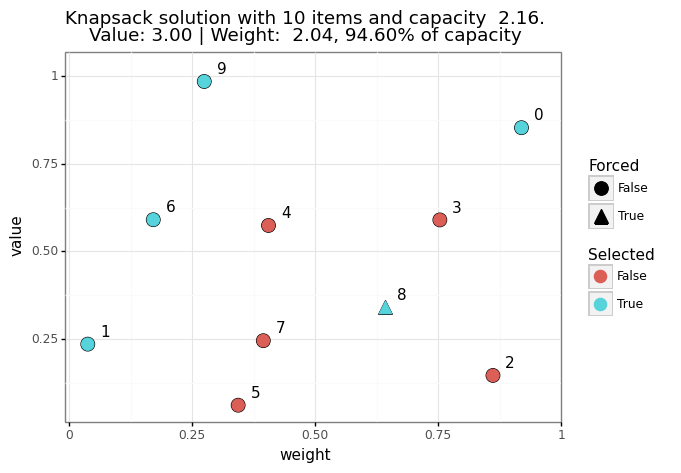

<ggplot: (8768177971478)>

In [9]:
plot_knapsack(kp, force_selected=[8])

### Answers

So now we know item #8 was not put in the knapsack because it would cause a `0.30` value loss w.r.t. the optimal solution. 

Hence, if someone asked to put the item in the knapsack, we should ask for a payment of at least `0.30` to recover losses.